In [1]:
import os
import h5py as h5
import numpy as np
import nrrd
import matplotlib.pyplot as plt

In [2]:
# file_seg = "../data/160_10-layer/volumes/00/160_10-layer_00_predictions.nrrd"
file_raw = "/Volumes/data/BIIAX_model_01-lowres-2024-02-08/160_10-layer_00_uint8_predictions.h5"

assert os.path.exists(file_raw)

In [3]:
with h5.File(file_raw,"r") as f:
    print(f.keys())
    for key in f.keys():
        print(key)
        if key == "predictions":
            pred = f[key][:]
            print(pred.shape)
            print(pred.nbytes/1024**2)
            print(pred.dtype)
        # if key == "volume_data":
        #     group = f[key]
        #     for subkey in group.keys():
        #         subarray = group[subkey][...]
        #         vol_config[subkey] = subarray

<KeysViewHDF5 ['predictions']>
predictions
(500, 2300, 2300)
2522.4685668945312
uint8


In [4]:
def extract_grid(volume, num_rows, num_cols):
    """
    Extract a grid of squares from a 2D NumPy array.

    Parameters:
    - image: 2D NumPy array representing the image
    - num_rows: Number of rows in the grid
    - num_cols: Number of columns in the grid

    Returns:
    - List of subarrays representing the grid squares
    """
    _, rows, cols = volume.shape
    square_size_row = rows // num_rows
    square_size_col = cols // num_cols
    subarrays = []
    for i in range(num_rows):
        row_subarrays=[]
        for j in range(num_cols):
            subarray = volume[:,i * square_size_row:(i + 1) * square_size_row,
                             j * square_size_col:(j + 1) * square_size_col]
            row_subarrays.append(subarray)
        subarrays.append(row_subarrays)
    return subarrays



In [5]:
pred_ = np.argmax(pred,axis=0)

In [6]:
pred.shape

(500, 2300, 2300)

In [7]:
pred.dtype

dtype('uint8')

In [9]:
filename = "/Volumes/LaCie 1/scratch/160_10-layer/labels/00/subvolumes/160_10-layer_0055_prediction24_02_05.seg.nrrd"
readdata, header0 = nrrd.read(filename)
for key in header0.keys():
    print(key,header0[key])

type float
dimension 3
space left-posterior-superior
sizes [500 230 230]
space directions [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
kinds ['domain', 'domain', 'domain']
endian little
encoding gzip
space origin [0. 0. 0.]
Segment0_Color 0 0.188235 0.439216
Segment0_ColorAutoGenerated 0
Segment0_Extent 141 334 0 229 0 229
Segment0_ID Segment_1
Segment0_LabelValue 1
Segment0_Layer 0
Segment0_Name weft
Segment0_NameAutoGenerated 0
Segment0_Tags Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|
Segment1_Color 0.913725 0.823529 0.301961
Segment1_ColorAutoGenerated 0
Segment1_Extent 141 334 0 229 0 229
Segment1_ID Segment_2
Segment1_LabelValue 2
Segment1_Layer 0
Segment1_Name fill
Segment1_NameAutoGenerated 1
Segment1_Tags Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~

In [10]:
num_rows = 10  # Example: 4 rows in the grid
num_cols = 10  # Example: 4 columns in the grid

raw_subarrays = extract_grid(pred, num_rows, num_cols)
# seg_subarrays = extract_grid(seg, num_rows, num_cols)

In [11]:
def numpy_dtype_to_nrrd_dtype(dtype):
    """
    Convert NumPy dtype to NRRD dtype string.

    Parameters:
    - dtype: NumPy dtype object

    Returns:
    - NRRD dtype string
    """
    dtype_mapping = {
        np.uint8: 'uint8',
        np.uint16: 'uint16',
        np.uint32: 'uint32',
        np.uint64: 'uint64',
        np.int8: 'int8',
        np.int16: 'int16',
        np.int32: 'int32',
        np.int64: 'int64',
        np.float16: 'float16',
        np.float32: 'float32',
        np.float64: 'float64',
    }

    return dtype_mapping.get(dtype, 'unknown')


In [12]:
def create_nrrd_header(size, spacing, data_type='float', space='left-posterior-superior'):
    header = {
        'type': data_type,
        'dimension': len(size),
        'space dimension': len(size),
        'sizes': size,
        'space': space,
        # 'Segment0_LabelValue': 1,
        # 'Segment0_Layer': 0,
        # 'Segment0_Name': 'weft',
        # 'Segment0_NameAutoGenerated': 0,
        # 'Segment0_Color' : '0.0431373 0.2 0.439216',
        # 'Segment0_ColorAutoGenerated': 0,
        # 'Segment0_ID': 'Segment_1',
        # 'Segment0_Tags': 'Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|',
        # 'Segment1_Color' : (0.992157, 0.901961, 0.211765),
        # 'Segment1_ColorAutoGenerated': 0,
        # 'Segment1_ID': 'Segment_1_1',
        # 'Segment1_LabelValue': 2,
        # 'Segment1_Layer': 1,
        # 'Segment1_Name': 'fill',
        # 'Segment1_NameAutoGenerated': 0,
        # 'Segment1_Tags': 'Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^59441001^Lymph node~^^~Anatomic codes - DICOM master list~^^~^^|',
        # 'Segmentation_ContainedRepresentationNames': 'Binary labelmap|Closed surface|',
        # 'Segmentation_MasterRepresentation': 'Binary labelmap',
    }

    if len(spacing) == len(size):
        header['space directions'] =  np.diag(spacing).tolist()
        header['kinds'] = ['domain'] * len(size)
    
    if len(spacing) != len(size):
        header['space directions'] = [[np.nan, np.nan ,np.nan]] + np.diag(spacing).tolist()
        header['kinds'] = ['list'] + ['domain'] * (len(size)-1)
    
    
    
    header.update({
        'endian': 'little',
        'encoding': 'raw',
    })

    return header

In [15]:
segmentation = raw_subarrays[0][0]

In [23]:
(0.020618,)*3

(0.020618, 0.020618, 0.020618)

In [13]:
header0["spacing"] = (0.020618,)*3

for key in header0.keys():
    print(key,header0[key])

type float
dimension 3
space left-posterior-superior
sizes [500 230 230]
space directions [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
kinds ['domain', 'domain', 'domain']
endian little
encoding gzip
space origin [0. 0. 0.]
Segment0_Color 0 0.188235 0.439216
Segment0_ColorAutoGenerated 0
Segment0_Extent 141 334 0 229 0 229
Segment0_ID Segment_1
Segment0_LabelValue 1
Segment0_Layer 0
Segment0_Name weft
Segment0_NameAutoGenerated 0
Segment0_Tags Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|
Segment1_Color 0.913725 0.823529 0.301961
Segment1_ColorAutoGenerated 0
Segment1_Extent 141 334 0 229 0 229
Segment1_ID Segment_2
Segment1_LabelValue 2
Segment1_Layer 0
Segment1_Name fill
Segment1_NameAutoGenerated 1
Segment1_Tags Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~

In [15]:
path = os.path.join(os.path.dirname(file_raw),"subvolumes")
file_name = os.path.splitext(os.path.basename(file_raw))[0]

file_name = "160_10-layer_00_predictions"

flag = False

# VoxelSizeX = vol_config["VoxelSizeX"]
# VoxelSizeY = vol_config["VoxelSizeY"]
# VoxelSizeZ = vol_config["VoxelSizeZ"]

padding_row = pred.shape[1]//num_rows
padding_col = pred.shape[2]//num_cols
for n, ( raw_subs) in enumerate(raw_subarrays):
    for k, ( raw_sub) in enumerate(raw_subs):     

        row_start = n*padding_row
        row_end = (n+1)*padding_row

        col_start = k*padding_col
        col_end = (k+1)*padding_col

        fileout = file_name + "_%04d-%04d_%04d-%04d" %(row_start,row_end,col_start,col_end)
        print(fileout,"%01d%01d" %(n,k))
        
        
        nrrd.write(os.path.join(path,fileout + ".pred.nrrd"), raw_sub,header=header0)

        # np.save(os.path.join(path,fileout + ".pred.npy"), raw_sub)

        # with h5.File(os.path.join(path,fileout + ".pred.h5"), 'w') as fout:
            

        #     fout.create_dataset("labels", data = raw_sub)



160_10-layer_00_predictions_0000-0230_0000-0230 00
160_10-layer_00_predictions_0000-0230_0230-0460 01
160_10-layer_00_predictions_0000-0230_0460-0690 02
160_10-layer_00_predictions_0000-0230_0690-0920 03
160_10-layer_00_predictions_0000-0230_0920-1150 04
160_10-layer_00_predictions_0000-0230_1150-1380 05
160_10-layer_00_predictions_0000-0230_1380-1610 06
160_10-layer_00_predictions_0000-0230_1610-1840 07
160_10-layer_00_predictions_0000-0230_1840-2070 08
160_10-layer_00_predictions_0000-0230_2070-2300 09
160_10-layer_00_predictions_0230-0460_0000-0230 10
160_10-layer_00_predictions_0230-0460_0230-0460 11
160_10-layer_00_predictions_0230-0460_0460-0690 12
160_10-layer_00_predictions_0230-0460_0690-0920 13
160_10-layer_00_predictions_0230-0460_0920-1150 14
160_10-layer_00_predictions_0230-0460_1150-1380 15
160_10-layer_00_predictions_0230-0460_1380-1610 16
160_10-layer_00_predictions_0230-0460_1610-1840 17
160_10-layer_00_predictions_0230-0460_1840-2070 18
160_10-layer_00_predictions_023

1


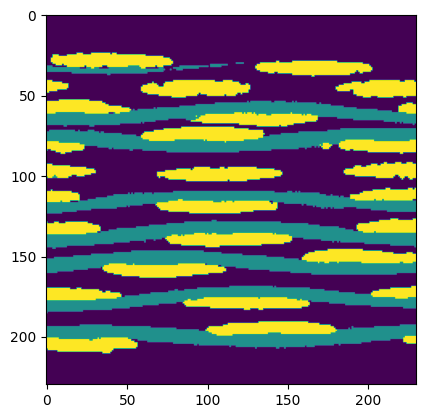

In [42]:
MCRpy = raw_subarrays[5][4]

masked_label_map = np.ma.masked_equal(MCRpy, 0)

idx0 = np.max(masked_label_map[masked_label_map == 1])


print(idx0)



plt.imshow(MCRpy[120:350,30,:])

np.save("test.npy",MCRpy[120:350,:,:])


(600, 230, 230)
1150 1380 1150 1380


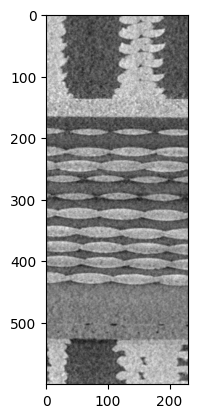

In [56]:
square_size_col = 230
square_size_row = 230

i = 5
j = 5


subarray = vol["raw"][:,i * square_size_row:(i + 1) * square_size_row,j * square_size_col:(j + 1) * square_size_col]

print(subarray.shape)
print(i * square_size_row,(i + 1) * square_size_row,j * square_size_col,(j + 1) * square_size_col)
plt.imshow(subarray[:,0,:],cmap="gray")